In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

from src import data_catalog
from src import tseries_mod
from src.utils import time_year_plus_frac
from src.utils_plot import plot_1var

%matplotlib inline

In [2]:
data_catalog.set_catalog('experiments')

active catalog: experiments


In [3]:
expr_dict = {
    'historical': {'clim_yrs': np.array([1990, 2015])},
    'esm-hist': {'clim_yrs': np.array([1990, 2015])},
    'historical-cmip5': {'clim_yrs': np.array([1990, 2015]), 'ext_expr': 'rcp85-cmip5'},
    'esm-hist-cmip5': {'clim_yrs': np.array([1990, 2015]), 'ext_expr': 'esm-rcp85-cmip5'},
}

cmip_var_metadata = {}
var_repl_dict_cmip5 = {}
var_repl_dict_non_cmip5 = {}

component = 'lnd'

cmip_var_metadata[component] = {
    'cVeg': {'cesm_varname': 'TOTVEGC', 'fmt': '0.0f'},
    'cCwd': {'cesm_varname': 'CWDC', 'fmt': '0.0f'},
    'cLitter': {'cesm_varname': 'TOTLITC', 'fmt': '0.1f'},
    'cSoil': {'cesm_varname': 'TOTSOMC', 'fmt': '0.0f'},
    'cProduct': {'cesm_varname': 'TOTPRODC', 'fmt': '0.1f'},
    'cLand': {'cesm_varname': 'TOTECOSYSC', 'fmt': '0.0f'},
    'gpp': {'cesm_varname': 'GPP', 'fmt': '0.1f'},
    'ra': {'cesm_varname': 'AR', 'fmt': '0.1f'},
    'npp': {'cesm_varname': 'NPP', 'fmt': '0.1f'},
    'rh': {'cesm_varname': 'HR', 'fmt': '0.1f'},
    'fFire': {'cesm_varname': 'COL_FIRE_CLOSS', 'fmt': '0.1f'},
    'nbp': {'cesm_varname': 'NBP', 'fmt': '0.2f'},
}

var_repl_dict_cmip5[component] = {}
var_repl_dict_non_cmip5[component] = {'TOTPRODC': ['TOT_WOODPRODC', 'CROPPROD1C']}

component = 'ocn'

cmip_var_metadata[component] = {
    'atmco2': {'cesm_varname': 'ATM_CO2', 'fmt': '0.1f'},
    'intdic': {'cesm_varname': 'DIC_vertint', 'fmt': '0.0f'},
    'fgco2': {'cesm_varname': 'FG_CO2', 'fmt': '0.2f'},
    'intpp': {'cesm_varname': 'photoC_TOT_zint', 'fmt': '0.1f'},
    'epc100': {'cesm_varname': 'POC_FLUX_100m', 'fmt': '0.2f'},
    'epcalc100': {'cesm_varname': 'CaCO3_FLUX_100m', 'fmt': '0.3f'},
}

var_repl_dict_cmip5[component] = {'photoC_TOT_zint': ['photoC_diat_zint', 'photoC_sp_zint', 'photoC_diaz_zint']}
var_repl_dict_non_cmip5[component] = {}

In [4]:
def get_ds(cesm_varnames, var_repl_dict, component, expr):
    cesm_varnames_tmp = cesm_varnames.copy()
    for varname, repl_list in var_repl_dict.items():
        cesm_varnames_tmp.remove(varname)
        cesm_varnames_tmp.extend(repl_list)
    ds = tseries_mod.tseries_get_vars(cesm_varnames_tmp, component, expr, freq='ann')
    for varname, repl_list in var_repl_dict.items():
        da_list = [ds[varname_repl] for varname_repl in repl_list]
        ds[varname] = xr.concat(da_list, 'dim_tmp').sum('dim_tmp')

    # extend ds with ext_expr, if specified
    if expr in expr_dict and 'ext_expr' in expr_dict[expr]:
        ext_expr = expr_dict[expr]['ext_expr']
        ds_ext = get_ds(cesm_varnames, var_repl_dict, component, ext_expr)
        df = data_catalog.find_in_index(experiment=ext_expr)
        branch_year = df['parent_branch_year'].unique()[0]
        # use ds up to branch_year, and ds_ext afterwards
        # assume start year in ds_ext is the same as branch_year,
        # so time in ds_ext does not need to be offset
        ds = xr.concat([ds.sel(time=slice(None, f'{branch_year}-01-01')), ds_ext], 'time')

    return ds

In [5]:
def gen_ds_dict(component, cmip_var_metadata, var_repl_dict_cmip5, var_repl_dict_non_cmip5):
    ds_dict = {}

    cesm_varnames = [metadata['cesm_varname'] for metadata in cmip_var_metadata.values()]

    for expr, expr_metadata in expr_dict.items():
        print(f'expr={expr}')
        var_repl_dict = var_repl_dict_cmip5 if 'cmip5' in expr else var_repl_dict_non_cmip5
        ds = get_ds(cesm_varnames, var_repl_dict, component, expr)
        t_expr = time_year_plus_frac(ds, 'time')

        clim_yrs = expr_metadata['clim_yrs']
        clim_slice = slice(f'{clim_yrs[0]:04d}-01-01', f'{clim_yrs[1]:04d}-01-01')
        ds_clim = ds.sel(time=clim_slice).mean('time')

        df = data_catalog.find_in_index(experiment=expr)

        parent_expr = df['parent_experiment'].unique()[0]
        print(f'parent_expr={parent_expr}')
        ds_parent = get_ds(cesm_varnames, var_repl_dict, component, parent_expr)

        # extract parent_branch_year values for each ensemble member from DataFrame

        if 'ensemble' in ds.dims:
            branch_years = np.zeros(ds.dims['ensemble'], dtype=np.int64)
            for ensemble in range(ds.dims['ensemble']):
                branch_years[ensemble] = df.loc[df['ensemble'] == ensemble]['parent_branch_year'].unique()[0]
        else:
            branch_years = df['parent_branch_year'].unique()[0]
        print(f'branch_years={branch_years}')

        parent_yr_del = 0

        ds_anom = ds_clim.copy(deep=True)
        for cesm_varname in cesm_varnames:
            if 'ensemble' in ds.dims:
                for ensemble in range(ds.dims['ensemble']):
                    parent_yrs = clim_yrs - np.int(np.floor(t_expr[0])) + branch_years[ensemble]
                    parent_yrs[0] -= parent_yr_del
                    parent_yrs[1] += parent_yr_del
                    parent_slice = slice(f'{parent_yrs[0]:04d}-01-01', f'{parent_yrs[1]:04d}-01-01')
                    parent_vals = ds_parent[cesm_varname].sel(time=parent_slice).mean('time')
                    ds_anom[cesm_varname].isel(ensemble=ensemble).values -= parent_vals
            else:
                parent_yrs = clim_yrs - np.int(np.floor(t_expr[0])) + branch_years
                parent_yrs[0] -= parent_yr_del
                parent_yrs[1] += parent_yr_del
                parent_slice = slice(f'{parent_yrs[0]:04d}-01-01', f'{parent_yrs[1]:04d}-01-01')
                parent_vals = ds_parent[cesm_varname].sel(time=parent_slice).mean('time')
                ds_anom[cesm_varname].values -= parent_vals

        ds_dict[expr] = ds
        ds_dict[parent_expr] = ds_parent
        ds_dict[parent_expr+'_clim'] = ds_parent.mean('time')
        ds_dict[expr+'_clim'] = ds_clim
        ds_dict[expr+'_anom'] = ds_anom

    return ds_dict

In [6]:
def add_var_metadata(cmip_var_metadata, ds_dict, attrnames):
    # add variable metadata from generated ds_dict to cmip_var_metadata
    # assumes that metadata is the same in all Datasets, and can be retrieved from first ds
    ds0 = list(ds_dict.values())[0]
    for metadata in cmip_var_metadata.values():
        for attrname in attrnames:
            metadata[attrname] = ds0[metadata['cesm_varname']].attrs[attrname]

In [7]:
ds_dict = {}

In [8]:
component = 'lnd'
ds_dict[component] = gen_ds_dict(component, cmip_var_metadata[component], var_repl_dict_cmip5[component], var_repl_dict_non_cmip5[component])
add_var_metadata(cmip_var_metadata[component], ds_dict[component], ['units'])

expr=historical
parent_expr=piControl
branch_years=[601 631 661 501 691 721 751 781 811 841 871]
expr=esm-hist
parent_expr=esm-piControl
branch_years=[ 51 151]
expr=historical-cmip5
parent_expr=piControl-cmip5
branch_years=151
expr=esm-hist-cmip5
parent_expr=esm-piControl-cmip5
branch_years=351


In [9]:
component = 'ocn'
ds_dict[component] = gen_ds_dict(component, cmip_var_metadata[component], var_repl_dict_cmip5[component], var_repl_dict_non_cmip5[component])
add_var_metadata(cmip_var_metadata[component], ds_dict[component], ['units'])

expr=historical
parent_expr=piControl
branch_years=[601 631 661 501 691 721 751 781 811 841 871]
expr=esm-hist
parent_expr=esm-piControl
branch_years=[ 51 151]
expr=historical-cmip5
parent_expr=piControl-cmip5
branch_years=151
expr=esm-hist-cmip5
parent_expr=esm-piControl-cmip5
branch_years=351


In [10]:
def print_table(cmip_var_metadata, ds_dict, table_dict):
    val_dict = {}
    val_dict['varname'] = list(cmip_var_metadata.keys())
    val_dict['units'] = [metadata['units'] for metadata in cmip_var_metadata.values()]
    for hdr, col_desc in table_dict.items():
        ds = ds_dict[col_desc['expr']]
        val_col = []
        for metadata in cmip_var_metadata.values():
            val = col_desc['reduce_fcn'](ds[metadata['cesm_varname']].sel(region='Global').values)
            val_col.append(f'{val:{metadata["fmt"]}}')
        val_dict[hdr] = val_col
    df = pd.DataFrame(val_dict)
    df.columns = pd.MultiIndex.from_tuples([tuple(c.split('_')) if '_' in c else ('', c) for c in df.columns])
    print(df.to_string(index=False))
    return df

In [11]:
def print_tables(cmip_var_metadata, ds_dict):
    table_dict = {
        'CESM2_piControl': {'expr': 'piControl', 'reduce_fcn': np.mean},
        'CESM2_esm-piControl': {'expr': 'esm-piControl', 'reduce_fcn': np.mean},
        'CESM1(BGC)_piControl': {'expr': 'piControl-cmip5', 'reduce_fcn': np.mean},
        'CESM1(BGC)_esm-piControl': {'expr': 'esm-piControl-cmip5', 'reduce_fcn': np.mean},
    }
    print_table(cmip_var_metadata, ds_dict, table_dict)

    table_dict = {
        'CESM2_historical': {'expr': 'historical_clim', 'reduce_fcn': np.mean},
        'CESM2_std': {'expr': 'historical_clim', 'reduce_fcn': np.std},
        'CESM2_anomaly': {'expr': 'historical_anom', 'reduce_fcn': np.mean},
        'CESM2_anom-std': {'expr': 'historical_anom', 'reduce_fcn': np.std},
        'CESM1(BGC)_historical': {'expr': 'historical-cmip5_clim', 'reduce_fcn': np.mean},
        'CESM1(BGC)_anomaly': {'expr': 'historical-cmip5_anom', 'reduce_fcn': np.mean},
    }
    print_table(cmip_var_metadata, ds_dict, table_dict)

    table_dict = {
        'CESM2_esm-hist': {'expr': 'esm-hist_clim', 'reduce_fcn': np.mean},
        'CESM2_std': {'expr': 'esm-hist_clim', 'reduce_fcn': np.std},
        'CESM2_anomaly': {'expr': 'esm-hist_anom', 'reduce_fcn': np.mean},
        'CESM2_anomaly-std': {'expr': 'esm-hist_anom', 'reduce_fcn': np.std},
        'CESM1(BGC)_esm-hist': {'expr': 'esm-hist-cmip5_clim', 'reduce_fcn': np.mean},
        'CESM1(BGC)_anomaly': {'expr': 'esm-hist-cmip5_anom', 'reduce_fcn': np.mean},
    }
    print_table(cmip_var_metadata, ds_dict, table_dict)

    table_dict = {
        'CESM2_esm-piControl': {'expr': 'esm-piControl', 'reduce_fcn': np.mean},
        'CESM2_esm-hist': {'expr': 'esm-hist_clim', 'reduce_fcn': np.mean},
        'CESM2_anomaly': {'expr': 'esm-hist_anom', 'reduce_fcn': np.mean},
        'CESM1(BGC)_esm-piControl': {'expr': 'esm-piControl-cmip5', 'reduce_fcn': np.mean},
        'CESM1(BGC)_esm-hist': {'expr': 'esm-hist-cmip5_clim', 'reduce_fcn': np.mean},
        'CESM1(BGC)_anomaly': {'expr': 'esm-hist-cmip5_anom', 'reduce_fcn': np.mean},
    }
    df = print_table(cmip_var_metadata, ds_dict, table_dict)

    ncolumns = df.shape[1]
    column_format = 'lc' + (ncolumns-1)*'c'
    latex = df.to_latex(index=False, column_format=column_format, multicolumn_format='c')
    repl_dict = {
        'toprule': 'hline',
        'midrule': 'hline',
        'bottomrule': 'hline',
        'yr-1': 'yr$^{-1}$',
        'Pg': 'Pg C',
        '  & \\multicolumn': '  & & \\multicolumn'
    }
    for old, new in repl_dict.items():
        latex = latex.replace(old, new)
    print(latex)

In [12]:
component = 'lnd'
print_tables(cmip_var_metadata[component], ds_dict[component])

                       CESM2               CESM1(BGC)              
  varname    units piControl esm-piControl  piControl esm-piControl
     cVeg       Pg       546           552        601           603
     cCwd       Pg       121           122         70            70
  cLitter       Pg      32.4          32.4       10.7          10.7
    cSoil       Pg      1829          1399        494           494
 cProduct       Pg       0.1           0.1        0.0           0.0
    cLand       Pg      2528          2106       1175          1178
      gpp  Pg yr-1      96.5          97.1      118.7         118.9
       ra  Pg yr-1      57.8          58.4       76.8          76.9
      npp  Pg yr-1      38.7          38.7       41.9          41.9
       rh  Pg yr-1      37.0          37.2       39.8          39.8
    fFire  Pg yr-1       1.5           1.5        2.1           2.1
      nbp  Pg yr-1     -0.03          0.00       0.01          0.01
                        CESM2                   

In [13]:
component = 'ocn'
print_tables(cmip_var_metadata[component], ds_dict[component])

                        CESM2               CESM1(BGC)              
   varname    units piControl esm-piControl  piControl esm-piControl
    atmco2     ppmv     284.7         287.6      284.7         284.1
    intdic       Pg     37081         37087      36428         36427
     fgco2  Pg yr-1     -0.04         -0.01      -0.02         -0.02
     intpp  Pg yr-1      48.4          48.4       56.1          56.1
    epc100  Pg yr-1      7.00          7.00       8.07          8.06
 epcalc100  Pg yr-1     0.767         0.767      0.761         0.759
                         CESM2                         CESM1(BGC)        
   varname    units historical    std anomaly anom-std historical anomaly
    atmco2     ppmv      373.8    0.0    89.1      0.0      374.7    90.0
    intdic       Pg      37183      5     105        1      36537     105
     fgco2  Pg yr-1       2.05   0.03    2.09     0.02       2.03    2.06
     intpp  Pg yr-1       48.9    0.1     0.5      0.2       56.3     0.3
    

In [14]:
def gen_tseries_plots(cmip_var_metadata, ds_dict):
    expr = 'esm-piControl'
    t_expr = time_year_plus_frac(ds_dict[expr], 'time')
    year0 = np.floor(t_expr[0])
    df = data_catalog.find_in_index(experiment=expr)
    branch_year = df['parent_branch_year'].unique()[0]

    for cmip_varname, metadata in cmip_var_metadata.items():
        print(cmip_varname)
        expr_list = ['piControl', 'esm-piControl']
        plot_1var(metadata['cesm_varname'], [ds_dict[expr] for expr in expr_list], expr_list, region_val='Global',
                  xoffsets=[0, branch_year-year0],
                  yoffsets = [-427.0 if cmip_varname in ['cSoil', 'cLand'] else 0.0, 0.0])
        plt.show()
        expr_list = ['piControl-cmip5', 'esm-piControl-cmip5']
        plot_1var(metadata['cesm_varname'], [ds_dict[expr] for expr in expr_list], expr_list, region_val='Global')
        plt.show()

cVeg


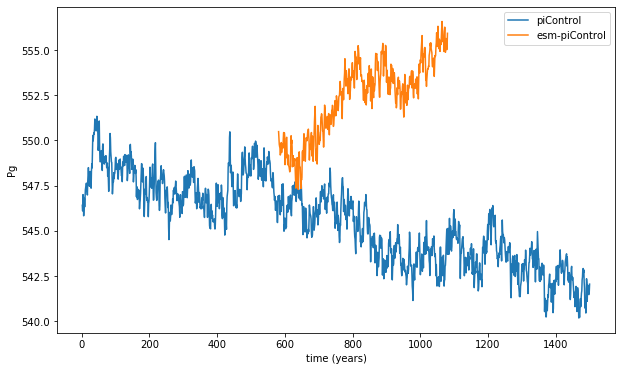

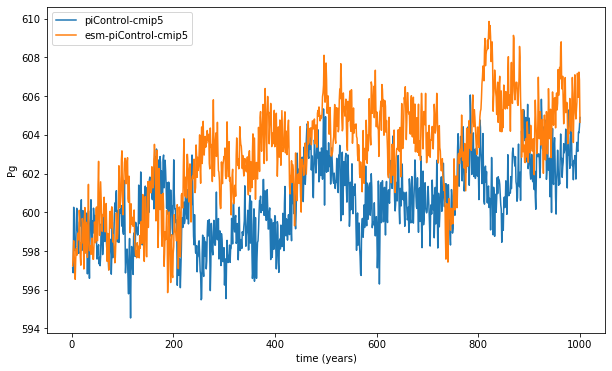

cCwd


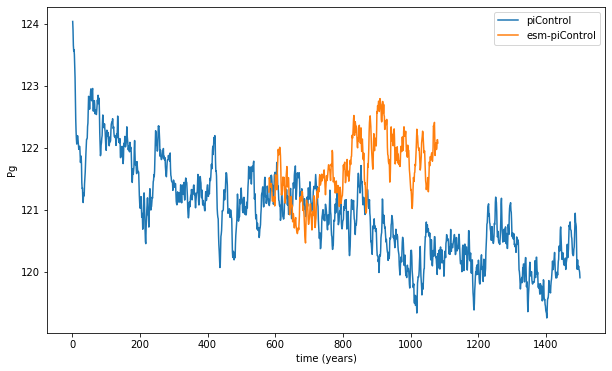

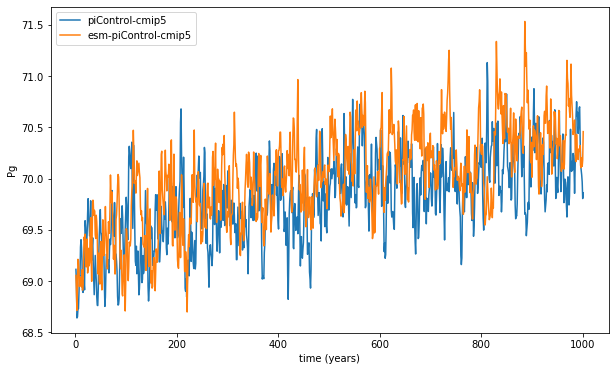

cLitter


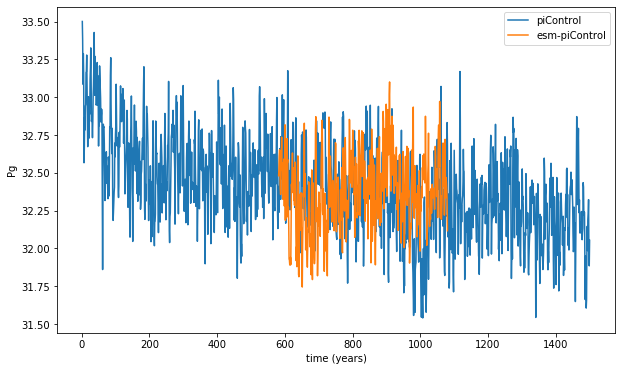

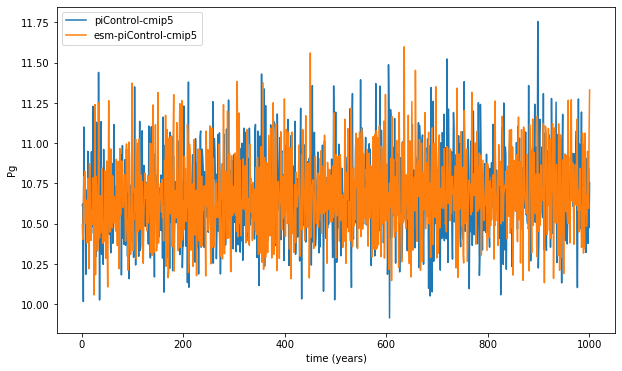

cSoil


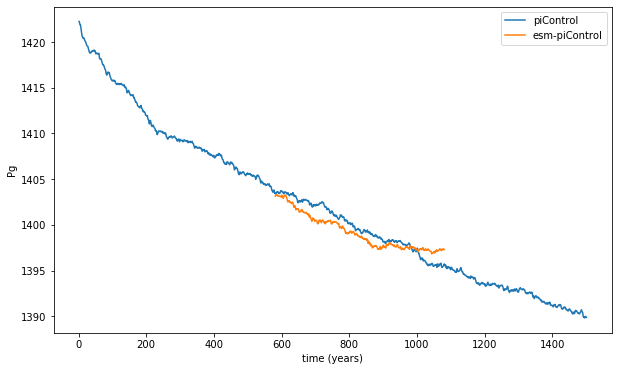

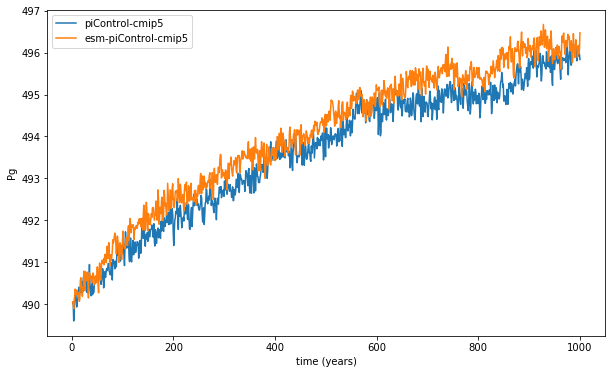

cProduct


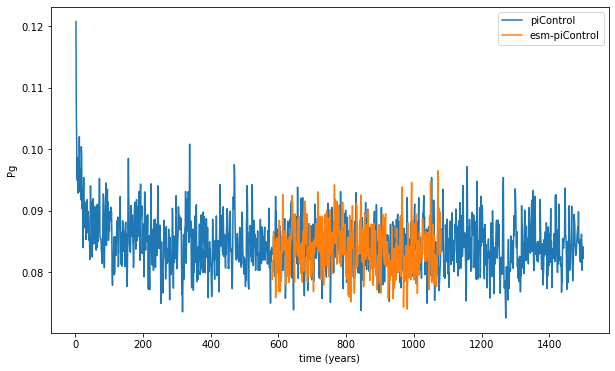

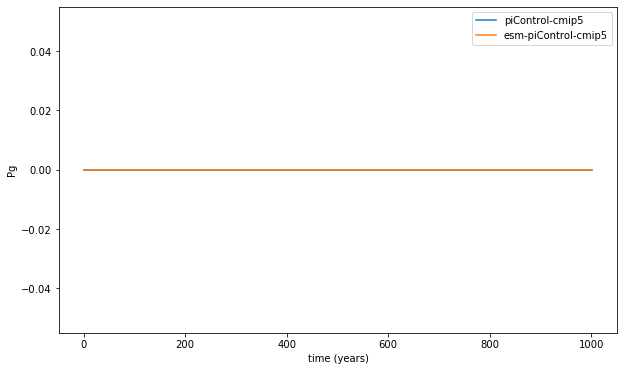

cLand


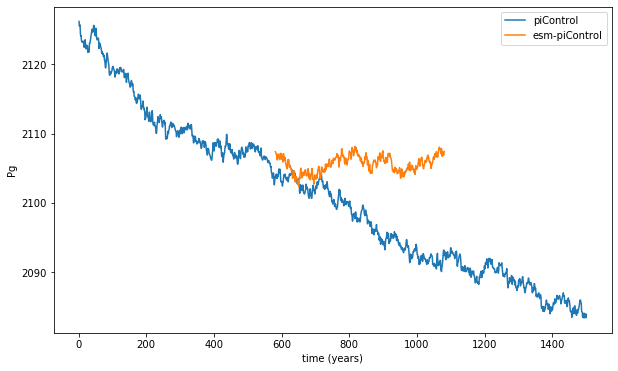

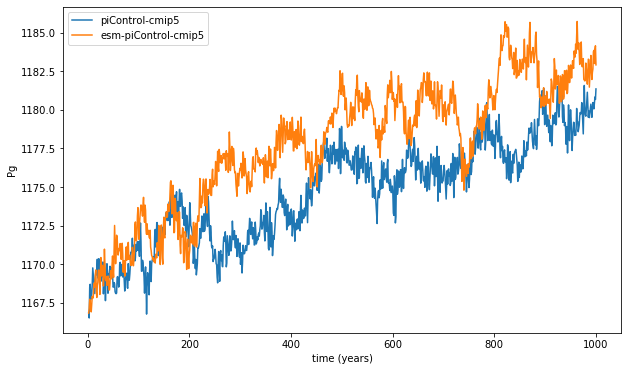

gpp


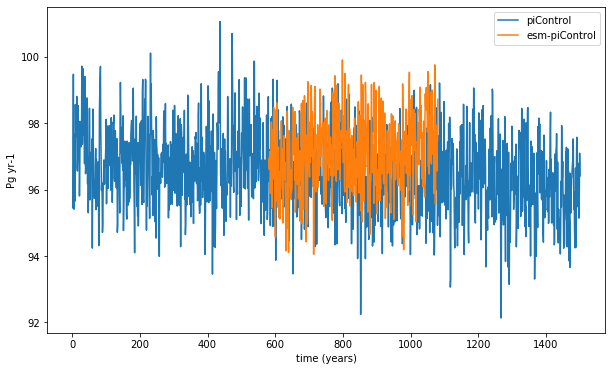

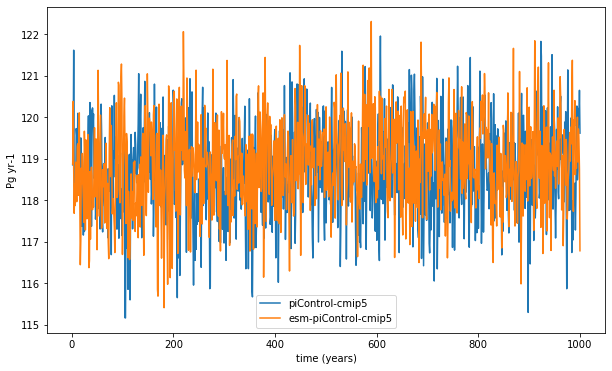

ra


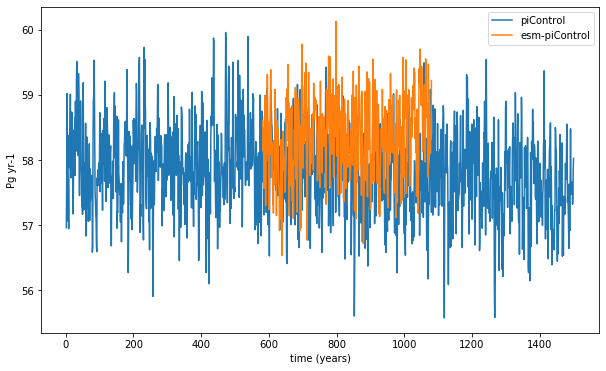

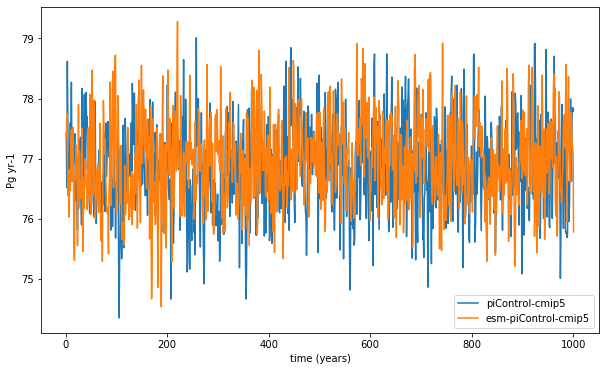

npp


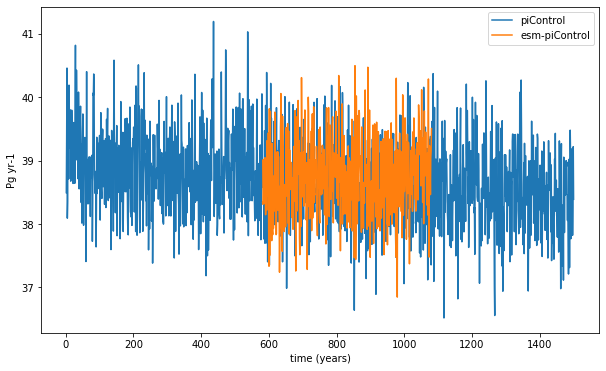

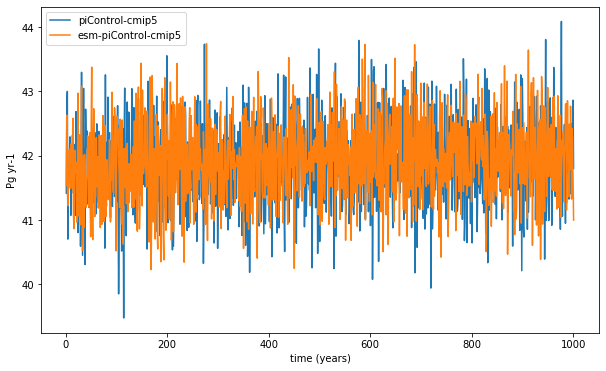

rh


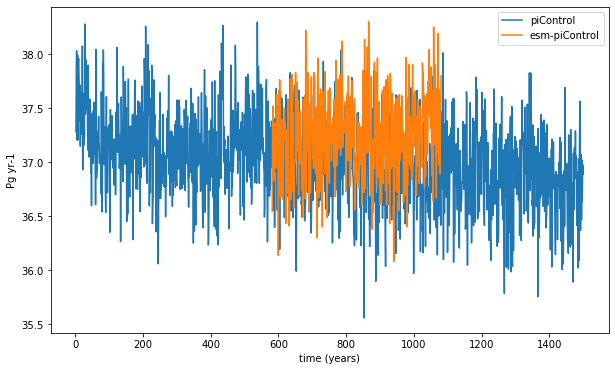

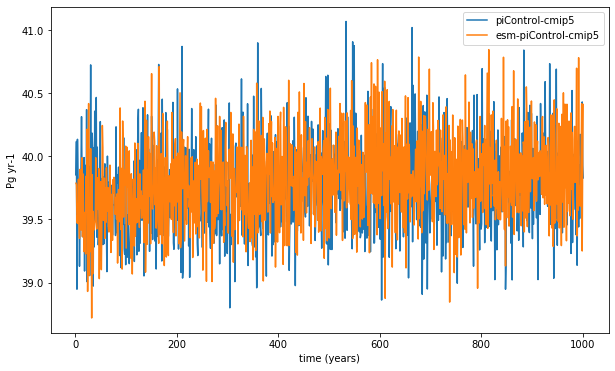

fFire


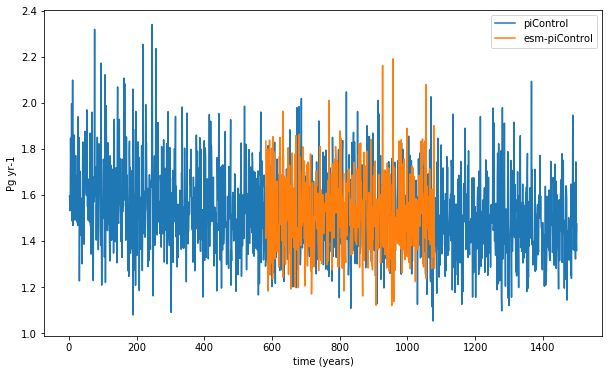

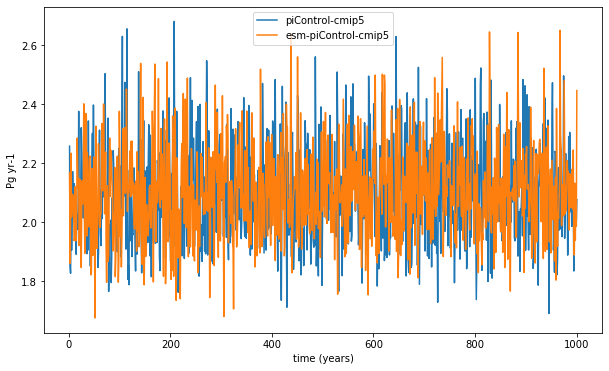

nbp


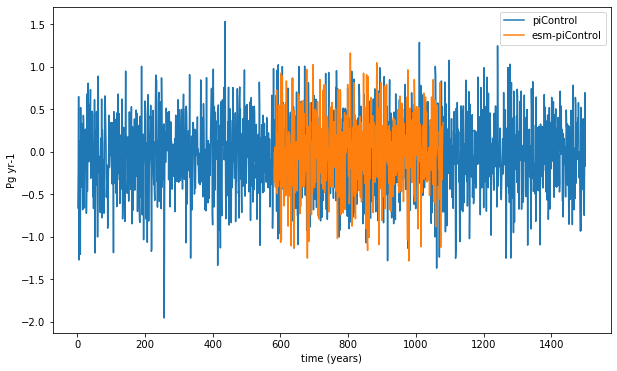

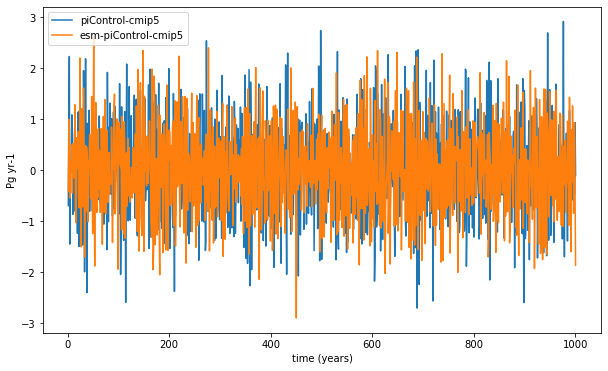

In [15]:
component = 'lnd'
gen_tseries_plots(cmip_var_metadata[component], ds_dict[component])

atmco2


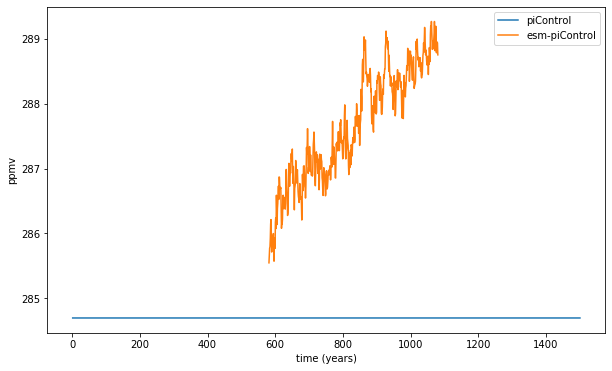

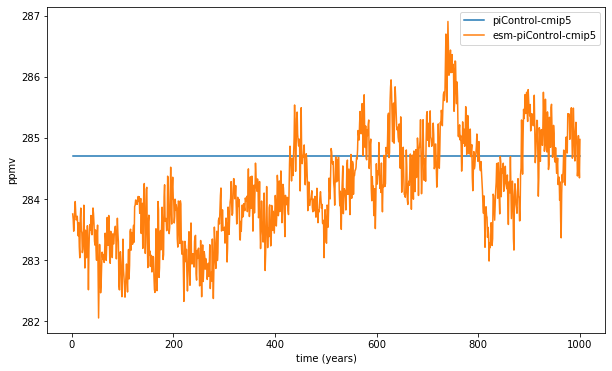

intdic


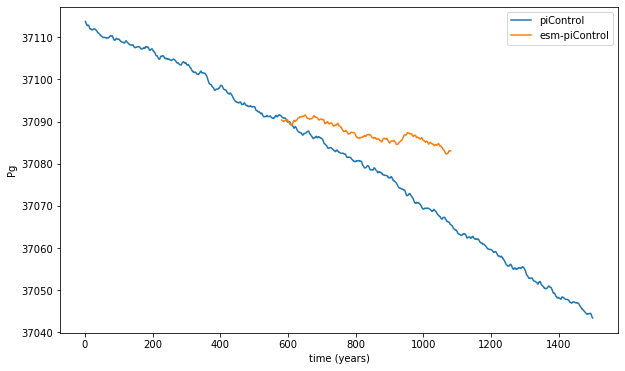

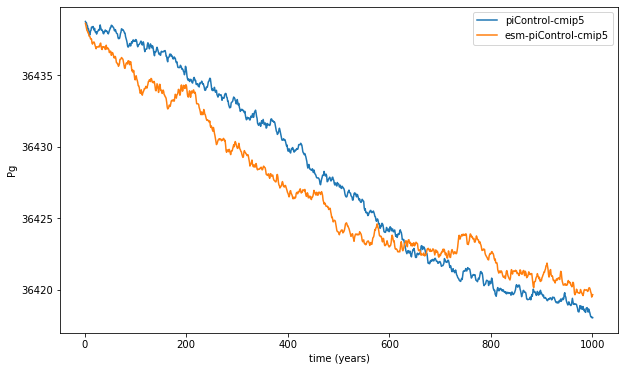

fgco2


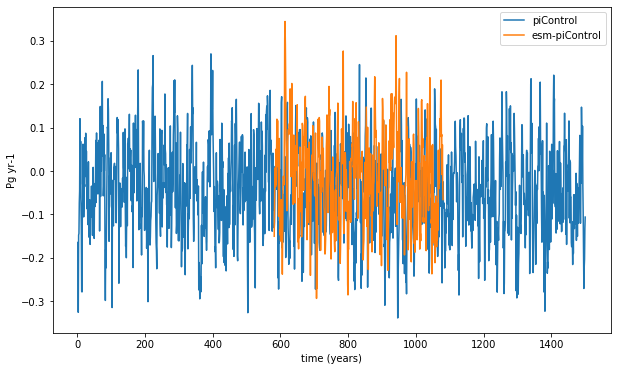

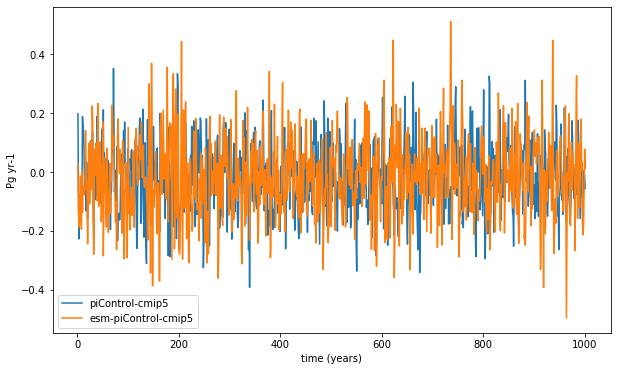

intpp


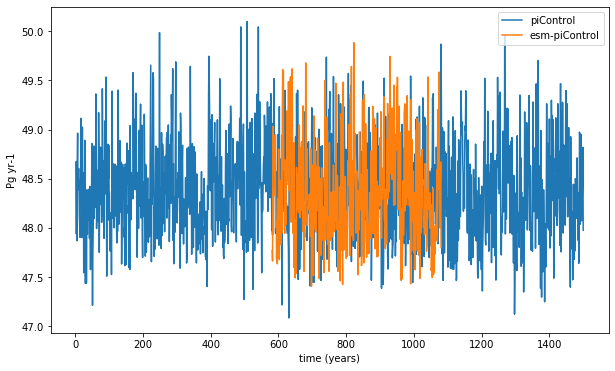

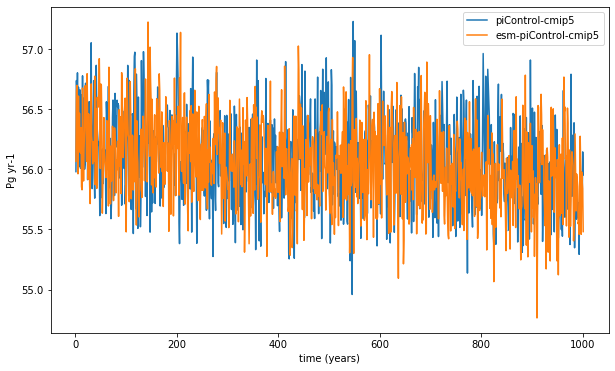

epc100


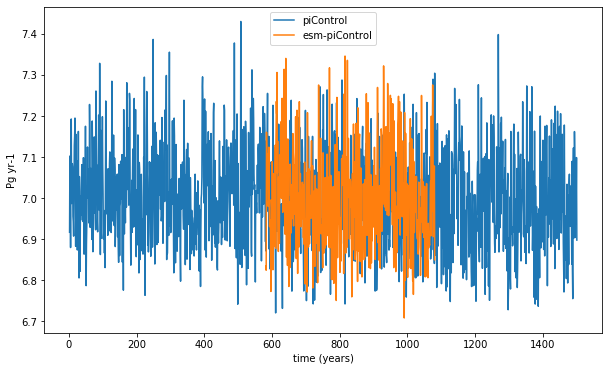

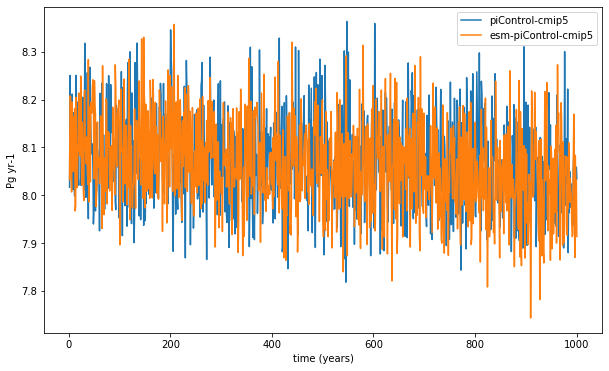

epcalc100


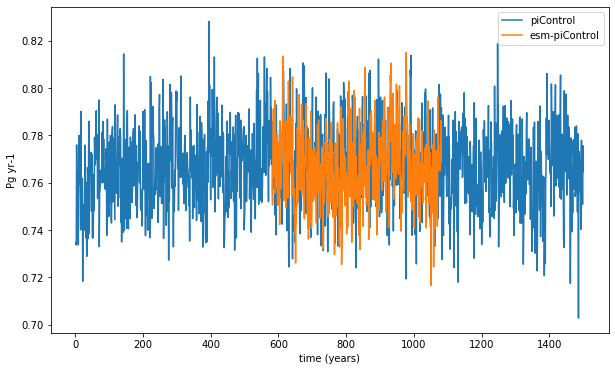

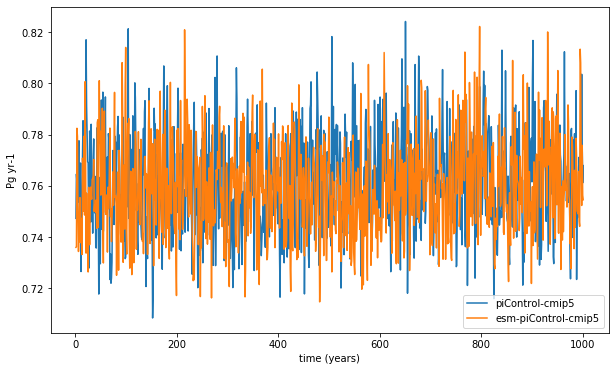

In [16]:
component = 'ocn'
gen_tseries_plots(cmip_var_metadata[component], ds_dict[component])